# Архитектура LeNet на примере датасета CIFAR10

![Архитектура LeNet](imgs/LeNet.png)

Архитектура нейронной сети LeNet — первая архитектура с использованием сверточных слоев она была предложена Яном ЛеКуном в 1998 году для классификации изображений из датасета MNIST. По нынешним меркам, это простая архитектура, все подробности детально описаны в статье [1].

Архитектура LeNet детально визуализирована на картинке выше. Каждый сверточный слой имеет размер ядра 5x5, ядра пуллинг-слоев имеют размер 2x2. Вот более детальная информация о каждом слое:

1. Сверточный слой C1, принимает 1 канал (3 в нашем случае) и возвращает 6 каналов.
2. AvgPool слой S2, имеет размер ядра 2x2 и шаг 2.
3. Сверточный слой C3, принимает 6 каналов и возвращает 16.
4. AvgPool слой S4, аналогичен слою S2.
5. Сверточный слой C5, принимает 16 каналов и возвращает 120. Так как на входе ему передается карта признаков размером 5x5, таким же, как и размер ядра, этот слой можно заменить на обычный полносвязный в нашем случае (при размере входных изображений 32x32) с 400 входными признаками и 120 выходными.
6. Полносвязный слой F6, имеет 120 входных признаков и 84 выходных.
7. Седьмой слой содержит в себе 10 RBF-нейронов (по одному на класс), каждый из которых имеет 84 входа. Вместо этого я буду использовать еще один полносвязный слой с 84 входными признаками и 10 выходными.

Между S2 и C3, S4 и C5 и далее между всеми полносвязными слоями используется функция гиперболического тангенса в качестве функции активации. Заметим, что в датасете MNIST, используемом в оригинале, изображения черно-белые, содержащие 1 канал, в нашем случае изображения 3-канальные, поэтому можно было бы увеличить количество выходных каналов у каждого сверточного слоя, например в 3 раза. Однако на практике это повлияло на итоговые метрики не значительно, поэтому я не стал этого делать.

Источники:

* [1] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, november 1998.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt

from helper_data import get_dataloaders_cifar10
from helper_train import train_cifar10_classifier, eval_cifar10_classifier, metric_accuracy

In [2]:
# global settings
torch.manual_seed(0)

LEARNING_RATE = 0.1
BATCH_SIZE = 128
VALIDATION_SIZE = 0.2

NUM_CLASSES = 10
NUM_EPOCHS = 10

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# class labels
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# get dataloaders
train_loader, test_loader = get_dataloaders_cifar10(batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# check data dimensions
train_iter = iter(train_loader)

image_batch, labels_batch = next(train_iter)

print(f"Image batch dimensions: {image_batch.size()}")
print(f"Labels batch dimensions: {labels_batch.size()}")

Image batch dimensions: torch.Size([128, 3, 32, 32])
Labels batch dimensions: torch.Size([128])


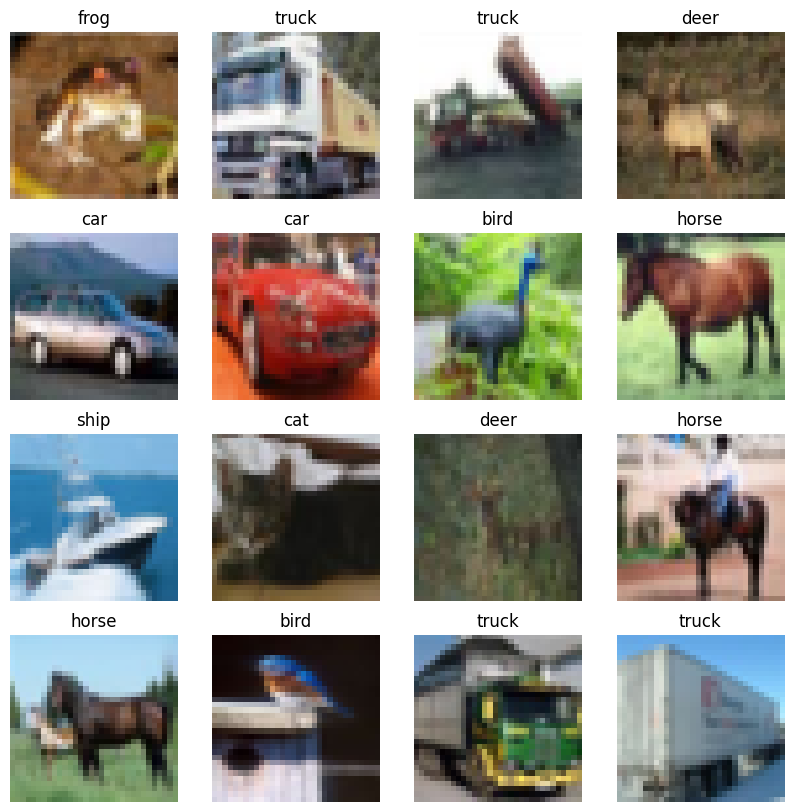

In [5]:
# plot dataset examples
for images, labels in train_loader:
    images_to_plot = images[0:16]
    labels_to_plot = labels[0:16]
    break

fig, ax = plt.subplots(4, 4, figsize=(10,10))
ax = ax.ravel()

for i in range(16):
    ax[i].imshow(images_to_plot[i].permute(1, 2, 0))
    ax[i].set_axis_off()
    ax[i].title.set_text(classes[labels_to_plot[i].item()])

In [6]:
# declare LeNet class
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.convolution = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Tanh(),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Tanh()
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        x = self.convolution(x)
        x = torch.flatten(x, 1)
        x = self.fully_connected(x)
                
        return x

In [7]:
# set optimizer and loss
lenet = LeNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet.parameters(), lr=LEARNING_RATE)

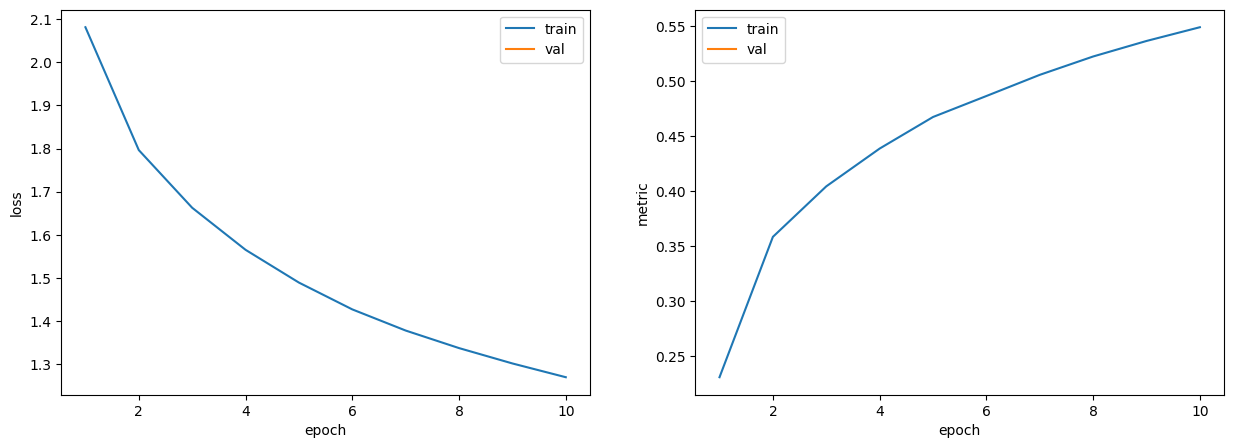

In [8]:
# train model
train_metrics, val_metrics = train_cifar10_classifier(
    model = lenet,
    optimizer = optimizer,
    criterion = criterion,
    accuracy = metric_accuracy,
    train_loader = train_loader,
    val_loader = None,
    num_epochs = NUM_EPOCHS,
    device = DEVICE
)

In [9]:
# pprint model params info
model = LeNet().to(DEVICE)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         AvgPool2d-2            [-1, 6, 14, 14]               0
              Tanh-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
         AvgPool2d-5             [-1, 16, 5, 5]               0
              Tanh-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              Tanh-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [10]:
# evaluate accuracy
lenet_acc = eval_cifar10_classifier(lenet, test_loader, classes, device=DEVICE)

Total accuracy: 51.91 %
Accuracy for class: plane is 52.9 %
Accuracy for class: car   is 76.8 %
Accuracy for class: bird  is 28.1 %
Accuracy for class: cat   is 37.3 %
Accuracy for class: deer  is 36.2 %
Accuracy for class: dog   is 36.9 %
Accuracy for class: frog  is 61.1 %
Accuracy for class: horse is 63.9 %
Accuracy for class: ship  is 68.1 %
Accuracy for class: truck is 57.8 %


# Улучшение модели

Классическое (почти) исполнение LeNet справилось с задачей классификации на датасете CIFAR10 весьма посредственно, однако гораздо лучше, чем случайное предсказание (10%). Попробуем улучшить accuracy, немного изменив нашу модель.

Прежде всего добавим параметр padding, чтобы информация по краям изображения учитывалась сверточными слоями. Для того, чтобы не менять количество слоев и в целом сохранить порядок архитектуры, слой C5 сделаем сверточным (как в оригинале, вместо полносвязного, как в реализации выше) с ядром размера 7x7. Такой размер необходим, чтобы корректно перераспределить данные в последующий полносвязный слой. Слои AvgPool заменим на MaxPool.

Кроме этого, все таки увеличим количество каналов, возвращаемых сверточными слоями в три раза. Количествно входных признаков у слоя F6 тоже придется увеличить.

In [11]:
# declare LeNet2 class
class LeNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.convolution = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=18, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Tanh(),
            nn.Conv2d(in_channels=18, out_channels=48, kernel_size=5, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Tanh(),
            nn.Conv2d(in_channels=48, out_channels=360, kernel_size=7),
            nn.Tanh()
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(in_features=360, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        x = self.convolution(x)
        x = torch.flatten(x, 1)
        x = self.fully_connected(x)
                
        return x

In [12]:
# set optimizer and loss
lenet2 = LeNet2()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet2.parameters(), lr=LEARNING_RATE)

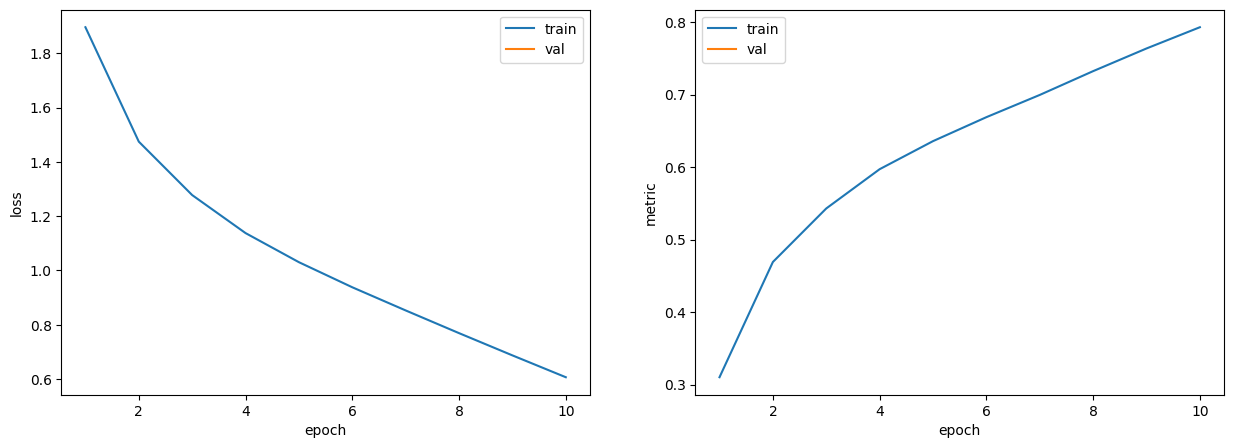

In [13]:
# train model
train_metrics, val_metrics = train_cifar10_classifier(
    model = lenet2,
    optimizer = optimizer,
    criterion = criterion,
    accuracy = metric_accuracy,
    train_loader = train_loader,
    val_loader = None,
    num_epochs = NUM_EPOCHS,
    device = DEVICE
)

In [14]:
# pprint model params info
model = LeNet2().to(DEVICE)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 18, 32, 32]           1,368
         MaxPool2d-2           [-1, 18, 16, 16]               0
              Tanh-3           [-1, 18, 16, 16]               0
            Conv2d-4           [-1, 48, 14, 14]          21,648
         MaxPool2d-5             [-1, 48, 7, 7]               0
              Tanh-6             [-1, 48, 7, 7]               0
            Conv2d-7            [-1, 360, 1, 1]         847,080
              Tanh-8            [-1, 360, 1, 1]               0
            Linear-9                   [-1, 84]          30,324
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 901,270
Trainable params: 901,270
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [15]:
# evaluate accuracy
lenet2_acc = eval_cifar10_classifier(lenet2, test_loader, classes, device=DEVICE)

Total accuracy: 67.15 %
Accuracy for class: plane is 67.6 %
Accuracy for class: car   is 71.6 %
Accuracy for class: bird  is 58.5 %
Accuracy for class: cat   is 50.9 %
Accuracy for class: deer  is 60.8 %
Accuracy for class: dog   is 42.7 %
Accuracy for class: frog  is 79.3 %
Accuracy for class: horse is 74.5 %
Accuracy for class: ship  is 83.7 %
Accuracy for class: truck is 81.9 %
